## Import the libraries

In [2]:

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.quantization
import torch
import time

import sys 
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from codes.helpers import load_and_save_model, load_and_quantize_gpt2model, measure_inference_time, plot_measurements

In [3]:
# Define model names and directories
# Define model names and directories
model_name = "facebook/blenderbot-400M-distill"
model_dir = "../models/blenderbot-400M-distill"
quantized_model_dir = "../models/quantized_blenderbot-400M-distill"
# model_name = "gpt2"
# model_dir = "../models/gpt2"
# quantized_model_dir = "../models/quantized_gpt2"


### Load and test the unquantized model

In [4]:

# Load and save the unquantized model
unquantized_model, tokenizer = load_and_save_model(model_name, model_dir)

# Test the unquantized model
input_text = "Hi, how are you?"
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Print the input IDs to verify
print(f"Input IDs: {input_ids}")

# Create an attention mask
attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

# Measure inference speed for the unquantized model
uq_start_time = time.time()
# Simplify the generation call to isolate issues
response_ids = unquantized_model.generate(
    input_ids,
    attention_mask=attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    max_length=100,
    do_sample=True,      # Enable sampling to allow diverse outputs
    top_k=50,            # Consider the top 50 tokens at each step
    top_p=0.95,          # Use nucleus sampling
    temperature=0.9,     # Control the randomness of predictions
    num_return_sequences=1,  # Generate one response
    repetition_penalty=2.0   # Penalize repetitions
)
unquantized_inference_time = time.time() - uq_start_time

# Print the response IDs to verify
# print(f"Response IDs: {response_ids}")

# Decode the response
response = tokenizer.decode(response_ids[0], skip_special_tokens=True)
print(f"Unquantized model response: {response}")

Model and tokenizer already exist in ../models/blenderbot-400M-distill
Input IDs: tensor([[4424,   19,  544,  366,  304,   38,    2]])
Unquantized model response:  Hi, how are you? more about ect. it's been a long time since I'd like to go for a longer time. kind of deal with stuff.


### Load and Test quantized Model

In [5]:

# Now let's quantize the model and test the quantized version
q_model, q_tokenizer = load_and_quantize_gpt2model(model_name, model_dir, quantized_model_dir)

# Measure inference speed for the quantized model
start_time = time.time()
# Test the quantized model
response_ids = q_model.generate(
    input_ids,
    attention_mask=attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    max_length=100,
    do_sample=True,      # Enable sampling to allow diverse outputs
    top_k=50,            # Consider the top 50 tokens at each step
    top_p=0.95,          # Use nucleus sampling
    temperature=0.9,     # Control the randomness of predictions
    num_return_sequences=1,  # Generate one response
    repetition_penalty=2.0   # Penalize repetitions
)
quantized_inference_time = time.time() - start_time

# Decode the response
quantized_response = q_tokenizer.decode(response_ids[0], skip_special_tokens=True)
print(f"Quantized model response: {quantized_response}")

Quantized model and tokenizer already exist in ../models/quantized_blenderbot-400M-distill


/Users/tangotew/miniconda3/envs/llm_quant/lib/python3.9/site-packages/torch/_utils.py:382: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


Quantized model response:  Hi, how are you? I have learned how to get back on.  Sorry about that.


## Measure the Optimization rate: 
How much did quantization saved on the size

In [6]:
# Measure and compare the sizes of the models
unquantized_model_size = sum(os.path.getsize(os.path.join(model_dir, f)) for f in os.listdir(model_dir) if os.path.isfile(os.path.join(model_dir, f)))
quantized_model_size = sum(os.path.getsize(os.path.join(quantized_model_dir, f)) for f in os.listdir(quantized_model_dir) if os.path.isfile(os.path.join(quantized_model_dir, f)))

print(f"Size of the unquantized model: {unquantized_model_size / (1024 * 1024):.2f} MB")
print(f"Size of the quantized model: {quantized_model_size / (1024 * 1024):.2f} MB")
print(f"Size reduction: {(unquantized_model_size - quantized_model_size) / (1024 * 1024):.2f} MB ({((unquantized_model_size - quantized_model_size) / unquantized_model_size) * 100:.2f}%)")

Size of the unquantized model: 1241.35 MB
Size of the quantized model: 351.32 MB
Size reduction: 890.03 MB (71.70%)


### Measure Inference Time

In [7]:

print(f"Inference time (unquantized model): {unquantized_inference_time:.2f} seconds")
print(f"Inference time (quantized model): {quantized_inference_time:.2f} seconds")
print(f"Speedup: {unquantized_inference_time / quantized_inference_time:.2f}x")

Inference time (unquantized model): 3.11 seconds
Inference time (quantized model): 2.48 seconds
Speedup: 1.25x


### Understand where the model is hanging

In [8]:
# Measure and compare inference speeds
unquantized_inference_time, _ = measure_inference_time(unquantized_model, input_ids, attention_mask, tokenizer, model_type="unquantized")
quantized_inference_time, _ = measure_inference_time(q_model, input_ids, attention_mask, q_tokenizer, model_type="quantized")

print(f"Inference time (unquantized model): {unquantized_inference_time:.2f} seconds")
print(f"Inference time (quantized model): {quantized_inference_time:.2f} seconds")
print(f"Speedup: {unquantized_inference_time / quantized_inference_time:.2f}x")

STAGE:2024-06-29 05:21:58 66591:454334 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-06-29 05:21:58 66591:454334 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-29 05:21:58 66591:454334 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Inference time (unquantized model): 3.03 seconds
Inference time (quantized model): 2.99 seconds
Speedup: 1.01x


STAGE:2024-06-29 05:22:01 66591:454334 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-06-29 05:22:01 66591:454334 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-29 05:22:01 66591:454334 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


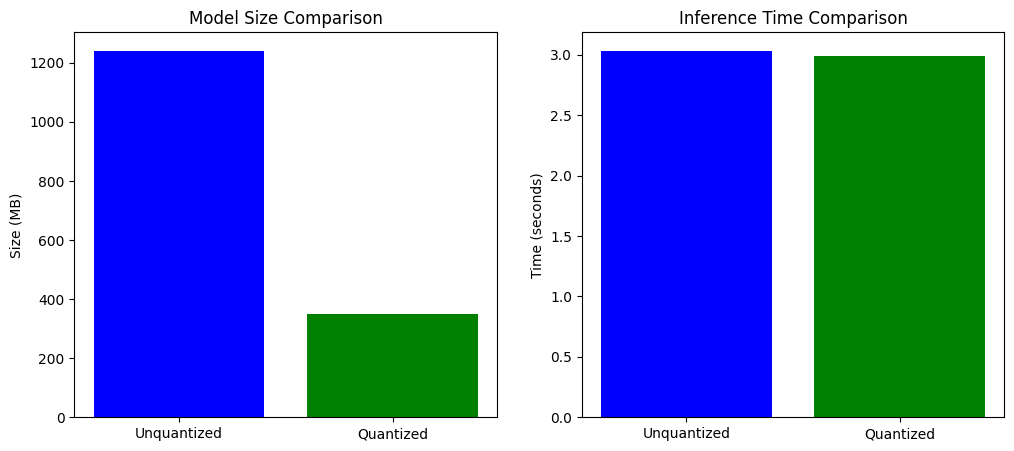

In [9]:
# Convert sizes to MB for plotting
unquantized_model_size_mb = unquantized_model_size / (1024 * 1024)
quantized_model_size_mb = quantized_model_size / (1024 * 1024)

# Plot the measurements
plot_measurements(unquantized_model_size_mb, quantized_model_size_mb, unquantized_inference_time, quantized_inference_time)

SyntaxError: cannot assign to operator (2911169554.py, line 1)